# Лабораторная работа 2: Корреляционная функция и моделирование импульсных пуассоновских процессов

In [1]:
# Не забудьте запустить этот кусок кода
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Корреляционная функция
Корреляционная функция случайного стационарного процесса определяется формулой:
$$\psi(\tau)=\langle \xi(t) \xi(t + \tau) \rangle - \overline{\xi}^2.$$ 

В случае эргодичности второго порядка усреднение по ансамблю можно заменить усреднением по времени: $$\psi(\tau)= \lim_{T\to\infty} {1 \over T}\int\limits_0^T \xi(t) \xi(t + \tau) \,dt - \overline{\xi}^2.$$

При работе с конечными дискретными последовательностями интеграл переходит в сумму, а нахождение предела замещается вычислением при фиксированном $N$:$$\psi(m)= {1 \over N}\sum_{n=1}^{N} \xi(n) \xi(n + m) - \overline{\xi}^2.$$

1) Выберите одно из распределений библиотеки `scipy.stats` и сгенерируйте  выборку из $L = N + 2M + 1 = 10000$ элементов.

Далее посчитайте по формуле корреляционную функцию для значений $m \in [-M, M]$, где $M = 1000$. Способ реализации остается за вами. Однако настоятельно рекомендую вместо стандартных циклов `python` использовать по возможности операции `numpy` над массивами и диапазонную индексацию массивов. Это значительно ускорит время выполнения вашего кода. Еще быстрее код будет работать, если приспособить функцию `correlate` из библиотеки `numpy` вместо подсчета $2M+1$ суммы. 

Постройте график корреляционной функции.

Повторите действие для $L = 100000$ и $L = 1000000$. 

In [2]:
L = 10000
M = 1000
N = L - 1 - 2*M
m = np.random.choice(range(-M, M + 1))

loc, scale = 0, 1
rx = sps.norm(loc=loc, scale=scale)
x = rx.rvs(L)

In [17]:
L = 1000000
M = 1000
N = L - 1 - 2*M
m = np.random.choice(range(-M, M + 1))

loc, scale = 0, 1
rx = sps.norm(loc=loc, scale=scale)
x = rx.rvs(L)

In [18]:
phi = 1/N*np.correlate(x[M:N + M], x[M - m:N + M - m]) - np.mean(x[M:N + M])**2
phi

array([-0.00109508])

Полученная функция корреляции при увеличении $L$ стремится к $\psi(m)= \delta_{0m}D[\xi]$. Это связанно с некоррелированностью отсчетов генератора случайных числел `scipy.stats`. Подобные случайные процессы получили название дельта-коррелированных.

2) Далее в работе нам еще несколько раз понадобится корреляционная функция, поэтому логично переписать нахождение корреляционной функции в виде отдельной функции `Python`. 

Напишите функцию `def corr(sample, corr_limit)`, где `sample` – выборка (массив `numpy`), а `corr_limit` – значение $M$ (целое число). Результатом работы функции `corr` должна быть функция корреляции (массив `numpy`).

In [187]:
def corr(sample: np.ndarray, corr_limit) -> np.ndarray:
  L, M = sample.shape[0], corr_limit
  N = L - 1 - 2*M
  return np.array([
    1/N*np.correlate(sample[M:N + M], sample[M - m:N + M - m]) - np.mean(sample[M:N + M])**2 for m in range(-M, M + 1)
  ]).reshape(2*M + 1)

3) Проверьте корректность работы функции `corr`, переписав код из пункта 1 с её помощью.

In [30]:
L = 10000
M = 1000
N = L - 1 - 2*M
m = np.random.choice(range(-M, M + 1))

loc, scale = 0, 1
rx = sps.norm(loc=loc, scale=scale)
x = rx.rvs(L)

corr(x, 500)

array([[-0.01103429],
       [-0.01271163],
       [-0.0018848 ],
       ...,
       [-0.00305188],
       [-0.01654143],
       [-0.01498486]])

### Пуассоновский процесс с экспоненциальными импульсами
Сгенерируем процесс: 
$$\xi(n)= \sum_{\nu} a_\nu F(n - m_\nu)$$

$$F(n) = 
 \begin{cases}
   0 &\text{при $n < 0$}\\
   e^{-\alpha n} &\text{при $n \geq 0$}
 \end{cases}
 $$

$$ P(a_\nu = 1) = 1/2,   P(a_\nu = -1) = 1/2 $$

$$n \in [0:L-1]$$
Отсчеты $m_\nu$ распределены по Пуассону со средней плотностью импульсов $n_1$.
 
Параметры: $\alpha = {1 \over 100}$, $L = 1000000$, $n_1 = {1 \over 200}$.

Выбор способа генерации процесса остается за вами. Вы можете последовательно выполнить пункты 4-6, а можете написать свой собственный способ генерации, если есть такое желание. 

 4) Начнем с генерации импульса. Величина $1 \over \alpha$ отражает количество отсчетов, через которое значение импульса уменьшится в $e$ раз. Поэтому через $N_p = 500$ отсчетов значение импульса будет близко к $0$ и его вклад в итоговый случайны процесс будет незначительным. Поэтому импульс можно выразить массивом из $N_p$ элементов без серьезной потери точности.

 Создайте такой массив и постройте его график.

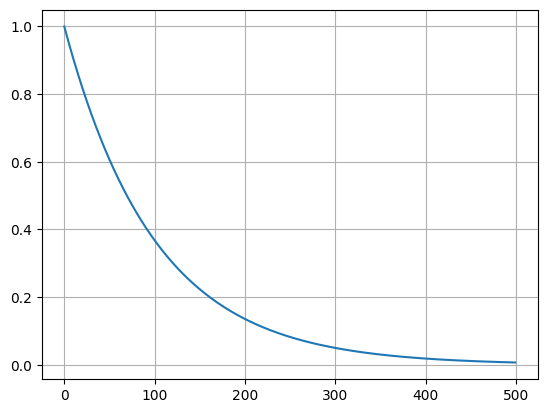

In [65]:
Np = 500
L = 1000000
alpha, n1 = 1/100, 1/200
n = np.arange(0, Np)
F = np.exp(-alpha*n)

plt.plot(n, F)
plt.grid()

5) Далее разберемся с отсчетами $m_\nu$. Для дискретного случая распределение Пуассона означает, что возникновение импульса при каждом отсчете определяется схемой Бернулли. А средняя плотность импульсов $n_1$ соответствует вероятности успеха в этой схеме.

Сгенерируйте выборку из $L + N_p$ элементов, распределенных по схеме Бернулли с вероятностью успеха $n_1$. Дополнительные $N_p$ отсчетов позволят избежать краевых эффектов в начале итоговой последовательности.

Сгенерируйте выборку из $L + N_p$ элементов, распределенных с вероятностями $ P(1) = 1/2,   P(-1) = 1/2 $ (для этого тоже можно использовать схему Бернулли).

Перемножьте полученные выборки. Если изменить подход к описанию случайного процесса и представить, что импульсы возникают при каждом отсчете времени (просто часть импульсов обладает нулевой амплитудой), то результат представляет собой амплитуды импульсов.

Постройте график для первых $10000$ отсчетов.


In [165]:
rx = sps.bernoulli(n1)

x = rx.rvs(size=(L + Np))

In [166]:
ry = sps.bernoulli(0.5, loc=-1)

y = ry.rvs(size=(L + Np))

In [168]:
a = x*y

6) Получите итоговый случайный процесс. Если представить, что импульсы возникают при каждом отсчете времени, то формула определяющая случайный процесс примет вид:

$$\xi(n)= \sum_{m = 0}^{N_p-1} a(n + N_p -m)F(m).$$

Постройте график для первых $10000$ отсчетов случайного процесса. 

In [177]:
def rv_ksi(L: int) -> np.ndarray:
    return np.array([
        np.correlate(a[n + 1: n + Np + 1], F[:Np]) for n in range(L)
    ]).reshape(L)

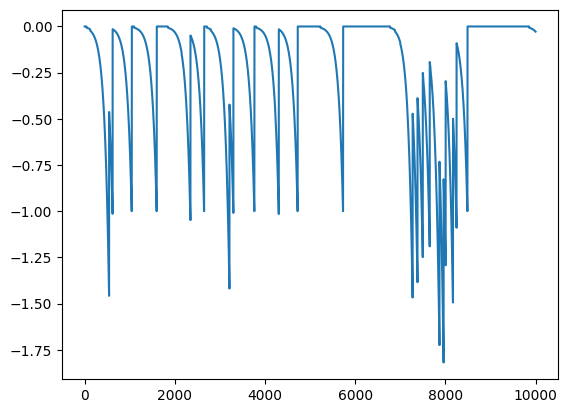

In [190]:
L = 10000
ksi = rv_ksi(L)

plt.plot(np.arange(L), ksi)

7) Найдите корреляционную функцию сгенерированного процесса. 

Рассчитайте теоретическую корреляционную функцию по формуле:

$$\psi(m) = {n_1 \over 2\alpha}e^{-\alpha|m|}$$

для $M = 1000$.

Постройте обе функции на одном графике. Пронаблюдайте, как результат моделирования сходится к теоретическому при разных значениях $L = 10000, 100000, 1000000$.

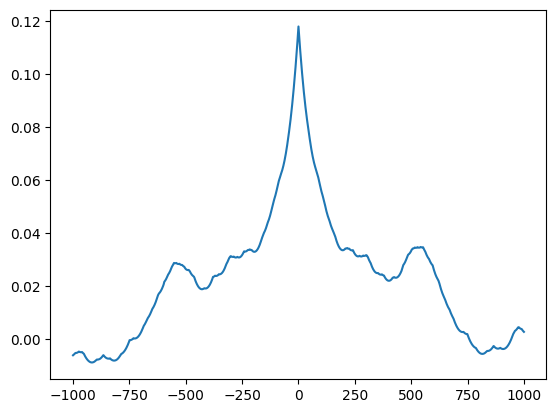

In [191]:
plt.plot(np.arange(-M, M + 1), corr(ksi, 1000))

### Телеграфный сигнал
Сгенерируем процесс:

$$\xi(n) = 
 \begin{cases}
   \xi(n-1) &\text{при $\eta(n) = 0$}\\
   -\xi(n-1) &\text{при $\eta(n) = 1$}
 \end{cases}
 $$

$$ P(\xi(0) = 1) = 1/2,   P(\xi(0) = -1) = 1/2 $$

$$n \in [0:L-1]$$
Величина $\eta(n)$ распределена по Пуассону со средней плотностью импульсов $n_1$.
 
Параметры: $L = 1000000$, $n_1 = {1 \over 200}$.

Выбор способа генерации процесса остается за вами. Вы можете выполнить пункт 8, а можете написать свой собственный способ генерации, если есть такое желание. 

 8) Сгенерируйте выборку из $L$ элементов, распределенных по схеме Бернулли с вероятностью успеха $n_1$.

Сгенерируйте первый элемент итогового случайного процесса, распределенный с вероятностями $ P(1) = 1/2,   P(-1) = 1/2 $ (для этого тоже можно использовать схему Бернулли).

Вычислите остальные элементы  итогового случайного процесса по формуле.

Постройте график для первых $10000$ отсчетов случайного процесса. 

In [193]:
L, n1 = 1000000, 1./200
mu = n1
rx = sps.poisson(mu)
eta = rx.rvs(size=L)

x1 = sps.bernoulli.rvs(n1, size=L)
x2 = sps.bernoulli.rvs(0.5, size=L, loc=-1)

9) Найдите корреляционную функцию сгенерированного процесса. 

Рассчитайте теоретическую корреляционную функцию по формуле:

$$\psi(m) = e^{-2n_1|m|}$$

для $M = 1000$.

Постройте обе функции на одном графике. Пронаблюдайте, как результат моделирования сходится к теоретическому при разных значениях $L = 10000, 100000, 1000000$.

In [156]:
# Здесь ваш код

### Пуассоновский процесс с прямоугольными импульсами случайной длительности
Сгенерируем процесс: 
$$\xi(n)= \sum_{\nu} F \left( {n - m_\nu \over \theta_\nu} \right)$$

$$F(\Theta) = 
 \begin{cases}
   1 &\text{при $\Theta \in [0,1]$}\\
   0 &\text{при $\Theta \notin [0,1]$}
 \end{cases}
 $$

$$ \rho(\theta_\nu) = {1\over \overline{\theta}}e^{-\theta_\nu / \overline{\theta}} $$

$$n \in [0:L-1]$$
Отсчеты $m_\nu$ распределены по Пуассону со средней плотностью импульсов $n_1$.
 
Параметры: $\overline{\theta} = 200$, $L = 1000000$, $n_1 = {1 \over 200}$.

Выбор способа генерации процесса остается за вами. Вы можете выполнить пункт 10, а можете написать свой собственный способ генерации, если есть такое желание. 

 10) Сгенерируйте выборку из $L$ элементов, распределенных по схеме Бернулли с вероятностью успеха $n_1$. Значение соответствует возникновению импульса в каждый отсчет времени.

Сгенерируйте выборку из $L$ элементов, распределенных с плотностью вероятности $\rho(\theta_\nu)$. Значение соответствует длительности импульса в каждый отсчет времени.

Для всех возникших импульсов $\nu$ прибавьте 1 к элементам итогового случайного процесса с индексами $n$ удовлетворяющими условию $m_\nu \leq n \leq m_\nu + [\theta_\nu]$, где $m_\nu$ – номер отсчета, в который возник импульс, $[x]$ – округление числа $x$ до целого. Возможно, что для корректной работы программы необходимо будет привести полученное значение к целому типу.

Постройте график для первых $10000$ отсчетов случайного процесса. 

In [157]:
# Здесь ваш код

11) Найдите корреляционную функцию сгенерированного процесса. 

Рассчитайте теоретическую корреляционную функцию по формуле:

$$\psi(m) = n_1 \overline{\theta} e^{-|m|/ \overline{\theta}}$$

для $M = 1000$.

Постройте обе функции на одном графике. Пронаблюдайте, как результат моделирования сходится к теоретическому при разных значениях $L = 10000, 100000, 1000000$.

In [158]:
# Здесь ваш код